In [1]:
PROJECT_ID = "formazione-riccardo-zanella" #@param {type: "string"}
REGION = 'us-central1' #@param {type: "string"}
BUCKET_NAME = "bbs-2021-opml4b-explainability" #@param {type:"string"}

In [2]:
TEST_FILE = 'gs://'+BUCKET_NAME+'/data/tabular_data/test.csv'
EXPORT_PATH = 'gs://' + BUCKET_NAME + '/mdl/tabular_data/tabular_data_20211029_152109/model'
MODEL = 'bike'
VERSION = 'v1'

In [3]:
import pandas as pd
import tensorflow as tf
import googleapiclient
from google.api_core.client_options import ClientOptions

2021-10-29 16:04:52.132821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-29 16:04:52.132856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import sys
sys.path.append('../../myproject')
from trainer_tabular_data.train import split_features_labels

# Load Test dataset

In [5]:
with tf.io.gfile.GFile(TEST_FILE) as f:
    test_data = pd.read_csv(f)

test_features, test_labels = split_features_labels(test_data)

# Get predictions

In [6]:

def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)
    service = googleapiclient.discovery.build(
        'ml', 'v1', client_options=client_options)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [7]:
# predictions = predict_json(PROJECT_ID, MODEL, [ {'dense_input': v.tolist()} for v in test_features.values[:5]], version=VERSION)
predictions = predict_json(
    PROJECT_ID,
    REGION,
    MODEL, 
    test_features[:5].values.tolist(),
    version=VERSION)

In [13]:
# Preview predictions on the first 5 examples from your test dataset
for i, val in enumerate(predictions):
    print('Predicted duration: {}'.format(round(val[0], 2)))
    print('Actual duration: {} \n'.format(test_labels.iloc[i]))

Predicted duration: 18.15
Actual duration: 22.0 

Predicted duration: 27.22
Actual duration: 31.0 

Predicted duration: 26.37
Actual duration: 23.0 

Predicted duration: 16.63
Actual duration: 14.0 

Predicted duration: 13.02
Actual duration: 9.0 



# Get explanations

Now that your model is deployed, you can use the AI Platform Prediction API to get feature attributions. You'll pass it a single test example here and see which features were most important in the model's prediction. Here you'll use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to get your prediction and explanation. You can also use `gcloud`.

### Format your explanation request

To make your AI Explanations request, you need to create a JSON object with your test data for prediction.

In [9]:
# Format data for prediction to your model
MODEL_INPUT = 'dense_input'
prediction_json = {MODEL_INPUT: test_features.iloc[0].values.tolist()}

### Send the explain request

You can use the Explainable AI SDK to send explanation requests to your deployed model.

In [10]:
import explainable_ai_sdk
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, VERSION, region=REGION)
ig_response = remote_ig_model.explain([prediction_json])

### Understanding the explanations response

First, let's look at the trip duration your model predicted and compare it to the actual value

In [11]:
attr = ig_response[0].get_attribution()

predicted = round(attr.example_score, 2)
print('Predicted duration: ' + str(predicted) + ' minutes')
print('Actual duration: ' + str(test_labels.iloc[0]) + ' minutes')

Predicted duration: 18.15 minutes
Actual duration: 22.0 minutes


Next let's look at the feature attributions for this particular example. Positive attribution values mean a particular feature pushed your model prediction up by that amount, and vice versa for negative attribution values.

Label Index 0
Example Score: 18.1540
Baseline Score: -62.9452
Approximation Error: 0.2391


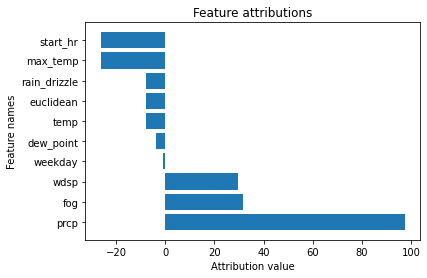

In [12]:
ig_response[0].visualize_attributions()

## Check your explanations and baselines

To better make sense of the feature attributions you're getting, you should compare them with your model's baseline. In most cases, the sum of your attribution values + the baseline should be very close to your model's predicted value for each input. Also note that for regression models, the `baseline_score` returned from AI Explanations will be the same for each example sent to your model. For classification models, each class will have its own baseline.

In this section you'll send 10 test examples to your model for prediction in order to compare the feature attributions with the baseline. Then you'll run each test example's attributions through two sanity checks in the `sanity_check_explanations` method.

In [ ]:
# Prepare 10 test examples to your model for prediction
pred_batch = []
for i in range(10):
    pred_batch.append({model.input.name.split(':')[0]: test_data.iloc[i].values.tolist()})

In [ ]:
test_response = remote_ig_model.explain(pred_batch)

In the function below you perform two sanity checks for models using Integrated Gradient (IG) explanations and one sanity check for models using Sampled Shapley.

In [ ]:
explain_method = 'integrated-gradients'
def sanity_check_explanations(example, mean_tgt_value=None, variance_tgt_value=None):
    passed_test = 0
    total_test = 1
    # `attributions` is a dict where keys are the feature names
    # and values are the feature attributions for each feature
    attr = example.get_attribution()
    baseline_score = attr.baseline_score
    # sum_with_baseline = np.sum(attribution_vals) + baseline_score
    predicted_val = attr.example_score

    # Sanity check 1
    # The prediction at the input is equal to that at the baseline.
    #  Please use a different baseline. Some suggestions are: random input, training
    #  set mean.
    if abs(predicted_val - baseline_score) <= 0.05:
        print('Warning: example score and baseline score are too close.')
        print('You might not get attributions.')
    else:
        passed_test += 1

    # Sanity check 2 (only for models using Integrated Gradient explanations)
    # Ideally, the sum of the integrated gradients must be equal to the difference
    # in the prediction probability at the input and baseline. Any discrepency in
    # these two values is due to the errors in approximating the integral.
    if explain_method == 'integrated-gradients':
        total_test += 1
        want_integral = predicted_val - baseline_score
        got_integral = sum(attr.post_processed_attributions.values())
        if abs(want_integral - got_integral) / abs(want_integral) > 0.05:
            print('Warning: Integral approximation error exceeds 5%.')
            print('Please try increasing the number of integrated gradient steps.')
        else:
            passed_test += 1

    print(passed_test, ' out of ', total_test, ' sanity checks passed.')

In [ ]:
for response in test_response:
    sanity_check_explanations(response)

## Understanding AI Explanations with the What-If Tool

In this section you'll use the [What-If Tool](https://pair-code.github.io/what-if-tool/) to better understand how your model is making predictions. See the cell below the What-if Tool for visualization ideas.

The What-If-Tool expects data with keys for each feature name, but your model expects a flat list. The functions below convert data to the format required by the What-If Tool.

In [ ]:
# This is the number of data points you'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 50

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


def create_list(ex_dict):
    new_list = []
    for i in feature_names:
        new_list.append(ex_dict[i])
    return new_list


def example_dict_to_input(example_dict):
    return {'dense_input': create_list(example_dict)}


from collections import OrderedDict
wit_data = test_data.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['duration'] = test_labels[:WHAT_IF_TOOL_SIZE]
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [ ]:
config_builder = WitConfigBuilder(
    wit_data_dict
).set_ai_platform_model(
    PROJECT_ID,
    MODEL,
    VERSION,
    adjust_example=example_dict_to_input
).set_target_feature('duration').set_model_type('regression')

WitWidget(config_builder)

### What-If Tool visualization ideas

On the x-axis, you'll see the predicted trip duration for the test inputs you passed to the What-If Tool. Each circle represents one of your test examples. If you click on a circle, you'll be able to see the feature values for that example along with the attribution values for each feature. 

* You can edit individual feature values and re-run prediction directly within the What-If Tool. Try changing `distance`, click **Run inference** and see how that affects the model's prediction
* You can sort features for an individual example by their attribution value, try changing the sort from the attributions dropdown
* The What-If Tool also lets you create custom visualizations. You can do this by changing the values in the dropdown menus above the scatter plot visualization. For example, you can sort data points by inference error, or by their similarity to a single datapoint.

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations or the What-if Tool, check out the resources here.

* [AI Explanations documentation](cloud.google.com/ml-engine/docs/ai-explanations)
* [Documentation for using the What-if Tool with Cloud AI Platform models ](https://cloud.google.com/ml-engine/docs/using-what-if-tool) 
* [What-If Tool documentation and demos](https://pair-code.github.io/what-if-tool/)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)